Question6 - Filtering with Sobel

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [2]:
input_image_path = Path("../data/a1images/einstein.png")  
output_folder    = Path("../data/output_images")
os.makedirs(output_folder, exist_ok=True)

out_mag_a = output_folder / "q6_mag_filter2D.png"
out_mag_b = output_folder / "q6_mag_manual.png"
out_mag_c = output_folder / "q6_mag_separable.png"
out_grid  = output_folder / "q6_results_grid.png"

In [3]:
# helpers 
def norm8(x: np.ndarray) -> np.uint8:
    x = x.astype(np.float32)
    mn, mx = float(x.min()), float(x.max())
    if mx - mn < 1e-6:
        return np.zeros_like(x, dtype=np.uint8)
    return np.clip((x - mn) * 255.0 / (mx - mn), 0, 255).astype(np.uint8)


In [4]:
# load grayscale 
g = cv.imread(str(input_image_path), cv.IMREAD_GRAYSCALE)
if g is None:
    raise FileNotFoundError(f"Could not find {input_image_path}")
gf = g.astype(np.float32)

# 3×3 Sobel kernels
Kx = np.array([[1, 0, -1],
               [2, 0, -2],
               [1, 0, -1]], dtype=np.float32)
Ky = Kx.T


In [5]:
# Using the existing filter2D to Sobel filter the image
Gx_a = cv.filter2D(gf, ddepth=cv.CV_32F, kernel=Kx, borderType=cv.BORDER_REPLICATE)
Gy_a = cv.filter2D(gf, ddepth=cv.CV_32F, kernel=Ky, borderType=cv.BORDER_REPLICATE)
Mag_a = np.hypot(Gx_a, Gy_a)
cv.imwrite(str(out_mag_a), norm8(Mag_a))


True

In [6]:
# own code to Sobel filter the image (manual conv)
def conv2_manual(img_f32: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    kh, kw = kernel.shape
    py, px = kh // 2, kw // 2
    pad = cv.copyMakeBorder(img_f32, py, py, px, px, cv.BORDER_REPLICATE)
    out = np.zeros_like(img_f32, dtype=np.float32)
    for y in range(out.shape[0]):
        for x in range(out.shape[1]):
            roi = pad[y:y+kh, x:x+kw]
            out[y, x] = float((roi * kernel).sum())
    return out

Gx_b = conv2_manual(gf, Kx)
Gy_b = conv2_manual(gf, Ky)
Mag_b = np.hypot(Gx_b, Gy_b)
cv.imwrite(str(out_mag_b), norm8(Mag_b))

True

In [7]:
# Using the separable property:  [[1,0,-1],[2,0,-2],[1,0,-1]] = [1,2,1]^T * [1,0,-1]
# Use cv.sepFilter2D for efficiency/equivalence
v = np.array([1, 2, 1], dtype=np.float32)   # smoothing (column)
h = np.array([1, 0, -1], dtype=np.float32)  # derivative (row)

# Gx: vertical smooth (v), horizontal derivative (h)
Gx_c = cv.sepFilter2D(gf, ddepth=cv.CV_32F, kernelX=h, kernelY=v, borderType=cv.BORDER_REPLICATE)
# Gy: horizontal smooth (v^T), vertical derivative (h^T)
Gy_c = cv.sepFilter2D(gf, ddepth=cv.CV_32F, kernelX=v, kernelY=h, borderType=cv.BORDER_REPLICATE)
Mag_c = np.hypot(Gx_c, Gy_c)
cv.imwrite(str(out_mag_c), norm8(Mag_c))

True

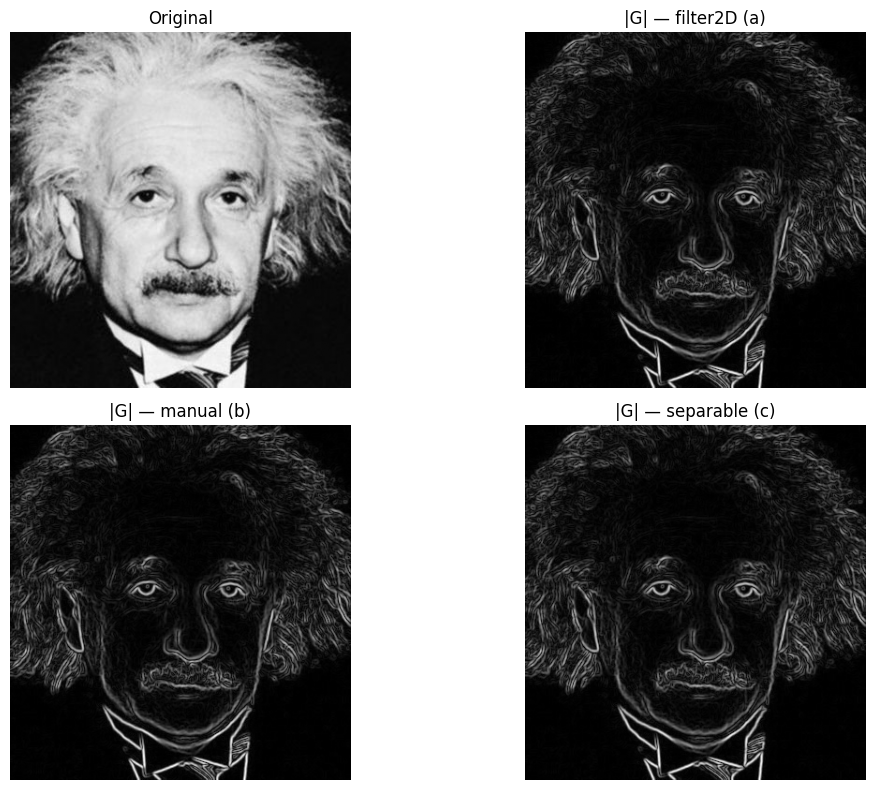

In [8]:
# visualize all
plt.figure(figsize=(12,8))
plt.subplot(2,2,1); plt.imshow(g, cmap="gray");          plt.title("Original");            plt.axis("off")
plt.subplot(2,2,2); plt.imshow(norm8(Mag_a), cmap="gray"); plt.title("|G| — filter2D (a)");   plt.axis("off")
plt.subplot(2,2,3); plt.imshow(norm8(Mag_b), cmap="gray"); plt.title("|G| — manual (b)");     plt.axis("off")
plt.subplot(2,2,4); plt.imshow(norm8(Mag_c), cmap="gray"); plt.title("|G| — separable (c)");  plt.axis("off")
plt.tight_layout(); plt.savefig(str(out_grid), dpi=150); plt.show()

In [9]:
# quantitative check
mse_a_b = float(np.mean((Mag_a - Mag_b) ** 2))
mse_a_c = float(np.mean((Mag_a - Mag_c) ** 2))
mse_b_c = float(np.mean((Mag_b - Mag_c) ** 2))
print(f"MSE (filter2D vs manual):    {mse_a_b:.6f}")
print(f"MSE (filter2D vs separable): {mse_a_c:.6f}")
print(f"MSE (manual vs separable):   {mse_b_c:.6f}")

MSE (filter2D vs manual):    0.000000
MSE (filter2D vs separable): 0.000000
MSE (manual vs separable):   0.000000
